Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 6: Building a Neural Network From Scratch - feedforward

J.B. Scoggins - Adrien Ehrhardt - Jesse Read

## Introduction

In this lab you will learn to create a simple multilayer perceptron (MLP) neural network from scratch using only the Numpy package for matrix-vector operations.  In order to train the network on several datasets, you will need to implement the back-propagation algorithm with gradient descent (in lab 07!). Before getting started, let's review the notations we will use in this lab and recall the stochastic gradient descent algorithm.

### Notation

We will consider simple feed-forward networks that can be described by the following recursive relationship,

$$
\begin{align}
&z^l = a^{l-1} W^l + b^l,\\
&a^l = \sigma^l(z^l),
\end{align}
$$

where $a^l$ is the output (activation) of layer $l$ which is a nonlinear function $\sigma^l$ of a linear transformation of the previous layer's output.  The linear transformation is performed using the weight matrix $W^l$ and bias vector $b^l$ associated with the layer $l$.  We will denote the last layer in the network with a capital $L$ superscript.  The recursion is stopped by setting $a^0 = x$, where $x$ is the input vector to our network.  Note that in the recursive expressions above, we implicitly assume that our input/output vectors are row vectors.  The reason for this will be apparent later.

Taking this notation into account, we see that a network with $L-1$ hidden layers is fully expressed by its $L$ weight matrices, bias vectors, and activation functions.  We can denote the set of trainable parameters in our network by $\theta = \{ W^1, \dots, W^L, b^1, \dots, b^L \}$.

In this lab, we are only concerned with supervised learning tasks.  Recall that in supervised learning, we have a dataset represented by a list of $(x, y)$ pairs where $x$ is the input to our model and $y$ is the desired output.

- For regression problems where we want to fit a function $y = f(x)$, $x$ is the independent variable vector, and $y$ is the function value.
- In classification problems, $x$ will correspond to a set of attributes and $y$ the corresponding label.

The goal of supervised learning is to "train" our network by adjusting its parameters in order to minimize a cost function over the entire training set,

$$
\min_\theta \mathcal{L} = \min_\theta \sum_{i=1}^N \ell^{(i)}
$$

where $\ell^{(i)} = \ell(\sigma^L(\sigma^{L-1}(\dots(x^{(i)}W^1 + b^1)\dots)W^L + b^L), y^{(i)})$ and $\ell(\hat{y}, y)$ denotes the particular form of the loss function being considered.  In this lab, we will use 2 different loss functions:

1. Quadratic Loss: $\ell(\hat{y}, y) = \|\hat{y} - y\|^2$
2. Cross-entropy Loss: $\ell(\hat{y}, y) = -[ y \ln\hat{y} + (1-y)\ln(1-\hat{y})]$

## Step 1: Build an untrainable network

Understanding (and implementing) the back-propagation algorithm can seem a little daunting at first. Therefore, let's start by building out the functions we need just to create a network that cannot be trained, but can predict (feedforward pass). First load the libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

*Python hints:* 
- Static methods are callable with uninstanciated class objects.
- `__call__` methods are retrieved when using parentheses with an instanciated class object.
- However, instanciation has precedence over `__call__`, so calling a Class like an other static method of that class or a function will not work (see [here](https://stackoverflow.com/questions/26793600/decorate-call-with-staticmethod)).
- `__init__` (typically used to customize the instanciated objects of a class) cannot return anything.
- The trick is thus to use it in conjunction with `__new__` (which creates the object and passes it to `__init__`).

In [2]:
class Activation(object):
    """
    Base activation node class
    """

    def __new__(self, x: float) -> float:
        """
        What to do when instantiating an object: this basically says Activation(x)
        will be equivalent to Activation()(x).

        :param float or np.array x: input of the activation
        :return: call the activation function
        :rtype: float or np.array
        """
        return self.__call__(x)

### Exercise 1: Implement the activation functions.

1. The easiest activation we can implement is the identity function which simply returns the input as itself.  Implement this below in the class template `Identity`. The `prime` function should implement the derivative of the activation. Note that it should work for single values (`float`) and vectors (`np.array`).

*Python hint:* see [`np.ones_like`](https://numpy.org/doc/stable/reference/generated/numpy.ones_like.html).

In [3]:
class Identity(Activation):
    """
    Identity activation node
    """
    @staticmethod
    def __call__(x: float) -> float:
        """
        Implements the identity activation function

        :param float or np.array x: input of the activation
        :return: identity of input
        :rtype: float or np.array
        """
        # YOUR CODE HERE
        return x
        
    @staticmethod
    def prime(x: float) -> float:
        """
        Implements the derivative of the identity activation function

        :param float or np.array: input of the activation
        :return: derivative of input
        :rtype: float or np.array
        """
        # YOUR CODE HERE
        return np.ones_like(x)

In [4]:
assert Identity(1) == 1
print(Identity(np.array([1, 1])))

[1 1]


2. The threshold activation function takes an input and returns 1 if the input is positive, otherwise 0.  Implement the `Threshold` class below. Note that it should work for single values (`float`) and vectors (`np.array`).

*Python hint:* see [`np.where`](https://numpy.org/doc/stable/reference/generated/numpy.where.html), and [`np.zeros_like`](https://numpy.org/doc/stable/reference/generated/numpy.zeros_like.html).

In [5]:
class Threshold(Activation):
    """
    Threshold activation node
    """
    @staticmethod
    def __call__(x: float) -> float:
        """
        Implements the threshold activation function

        :param float or np.array x: input of the activation
        :return: if x > 0, 1, else 0
        :rtype: float or np.array
        """
        # YOUR CODE HERE
        return np.where(x>0,1,0)
    
    @staticmethod
    def prime(x: float) -> float:
        """
        Implements the derivative of the threshold activation function

        :param float or np.array: input of the activation
        :return: derivative of input
        :rtype: float or np.array
        """
        # YOUR CODE HERE
        return np.zeros_like(x)

In [6]:
assert Threshold(0.5) == 1
print(Threshold(np.array([-0.1, 0.1])))

[0 1]


3. Recall that the sigmoid function is given by $\sigma(x) = \dfrac{1}{1 + \exp(-x)}$. Calculate its derivative.

*Hint*: you can do this on paper but be sure to insert a new markdown cell below and then click Edit > Insert Image.

*Recall* that the derivative of $\dfrac{1}{f(x)}$ is $-\dfrac{f'(x)}{f(x)^2}$. Rearrange the resulting expression so that only $\sigma$ appears.

We have :$\sigma(x) = \dfrac{1}{1 + \exp(-x)}$

Hence, $\sigma'(x) = \dfrac{\exp(-x)}{(1 + \exp(-x))^2}= \sigma(x) (1-\sigma(x))$

4. Implement the `Sigmoid` class below. Note that it should work for single values (`float`) and vectors (`np.array`).

In [25]:
class Sigmoid(Activation):    
    """
    Threshold activation node
    """
    @staticmethod
    def __call__(x: float) -> float:
        """
        Implements the sigmoid activation function

        :param float or np.array x: input of the activation
        :return: sigmoid transform of input
        :rtype: float or np.array
        """
        # YOUR CODE HERE
        return 1/(1+np.exp(-x))

    @staticmethod
    def prime(x: float) -> float:
        """
        Implements the derivative of the sigmoid activation function
        (you can make good use of Sigmoid(...)!)

        :param float or np.array: input of the activation
        :return: derivative of input
        :rtype: float or np.array
        """
        # YOUR CODE HERE
        return Sigmoid(x)*(1 - Sigmoid(x))

In [26]:
assert Sigmoid(0) == 0.5
print(Sigmoid(np.array([-1, 0, 1])))

[0.26894142 0.5        0.73105858]


4. Plot the activation functions and their derivative on the domain [-5, 5] with the function below. Are the graphical results satisfactory? (no answer expected).

In [27]:
def plot_activation(activation: Activation):
    x = np.arange(-5, 5, 0.01)
    plt.plot(x, activation(x))
    plt.plot(x, activation.prime(x))
    plt.legend((activation.__name__, activation.__name__ + " prime"))
    plt.show()

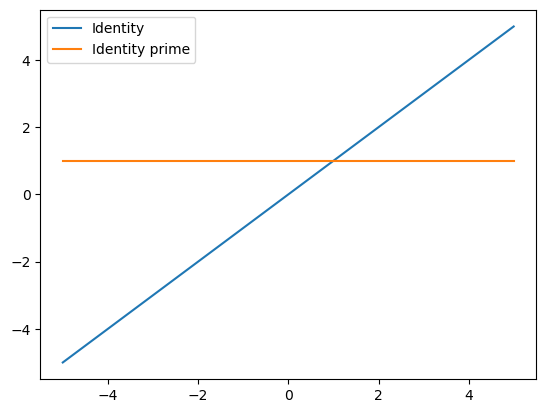

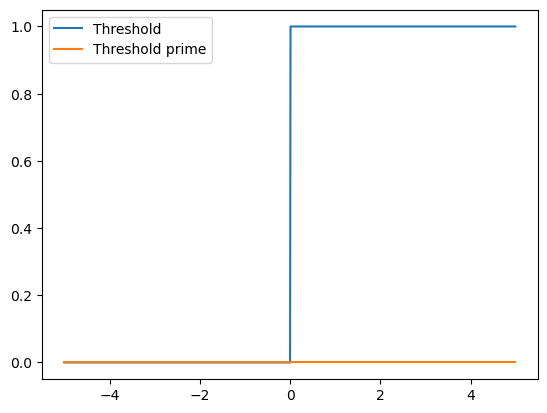

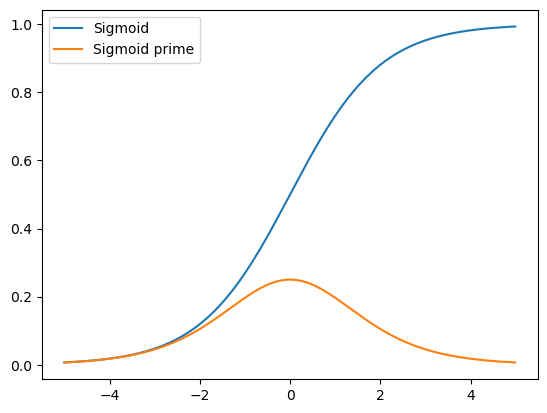

In [28]:
plot_activation(Identity)
plot_activation(Threshold)
plot_activation(Sigmoid)

### Exercise 2: First draft of the Network class

During this lab, we will build on the following python class called `Network` which will represent our neural net.  The `Network` class will keep track of the weights, biases, and activations needed to evaluate and train our model.  The following exercises will guide you through building up the class from the skeleton below.

In [29]:
class Network:
    """
    A simple implementation of a feed-forward artificial neural network.
    Work on this class throughout the entire exercise, rerunning this cell after each update.
    """
    
    def __init__(self, sizes: list, sigmas: list):
        """
        Construct a network given a list of the number of neurons in each layer and 
        a list of activations which will be applied to each layer.
        
        :param list sizes: A list of integers representing the number of nodes in each layer, 
        including the input and output layers.
        :param list activations: A list of callable objects representing the activation functions.
        Its size should be one less than sizes.
        """
        # Exercise 2.2
        # YOUR CODE HERE
        self.sizes=sizes
        self.sigmas=sigmas
        self.weights=[np.random.randn(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]
        self.biases = [np.random.randn(1, s) for s in sizes[1:]]
            
        

    def num_params(self) -> int:
        """Returns the total number of trainable parameters in this network."""
        # Exercise 2.3
        # YOUR CODE HERE
        sweights=np.sum([w.size for w in self.weights])
        sbiases=np.sum([b.size for b in self.biases])
        return  sweights+sbiases

    def feed_forward(self, x: np.array) -> np.array:
        """
        Evaluates the network for the given input and returns the result.
        
        :param numpy.array x: A numpy 2D-array where the columns represent input variables
        and rows represent independent samples.
        :return: output of the network
        :rtype: numpy.array
        """
        # Exercise 2.4
        a = x  # we start with a^0 = x, the input
        # YOUR CODE HERE
        for i in range(len(self.sizes)-1):
            z=np.dot(a,self.weights[i])+self.biases[i]
            a=self.sigmas[i](z)
        return a

1. From the recursion formulas above, write down the shapes of the weight matrices and bias vectors, given the number of neurons $d^l$ in layer $l$.

Weight matrix has shape $(d^{l-1}, d^l)$ and bias vector has shape (1,$d^l$)

2. Implement the init `__init__` function in `Network` above.

* Store `sizes` (a list of size $L + 1$ representing the respective size $d^l$ of each layer including the input) and `sigmas` (a list of size $L$ of callable functions representing the activation function in each layer) in attributes `sizes` and `sigmas`(...);

* Construct a list of weight matrices (in a `weights` attribute), a list of bias vectors (in a `biases` attribute) which are randomly initialized with normal distributions (see `np.random.randn`); pay attention to the size of each list and the shape of each element.

*Python hints*: `array[1:]` gives you all the array except the first entry; `array[:-1]` gives you all the array except the last entry; `for x, y in zip(a, b)` lets you iterate "simultaneously" through a pair of objects of same length.

In [30]:
# Test the network's initialization
assert Network([1], Sigmoid).sizes == [1]

3. Implement the `num_params` function in `Network` above.  Use your knowledge of the shapes of the weights and biases.

In [31]:
# Test the network's number of parameters
assert Network([1, 2, 2, 1], [Sigmoid, Sigmoid, Sigmoid]).num_params() == 13

4. Implement the `feed_forward` function in `Network` above. Use the recurrence relations discussed in the Notation section, in particular:

$$z^l = a^{l-1} W^l + b^l,\\
a^l = \sigma^l(z^l).$$

In [32]:
# Test the network's feedforward result
assert Network([1, 2, 2, 1], [Sigmoid, Sigmoid, Sigmoid]).feed_forward(np.array([1])).shape[0] == 1

5. Create a `network` with 4 inputs, 2 hidden layers of 5 nodes each, and 1 output (use any activation). This network could typically be used with the `iris` dataset, since we have 4 features (petal/sepal length/width) and 1 output (setosa/versicolor).

In [33]:
network = Network([4, 5, 5, 1], [Sigmoid, Sigmoid, Sigmoid])  # <- TO UNCOMMENT AND COMPLETE
# YOUR CODE HERE

6. Print the weights and biases of the network and confirm they are intialized correctly (shape and values).

In [16]:
for index, weight in enumerate(network.weights):
    print(f"\nW^{index}")
    print("Shape:", weight.shape)
    print(weight)


W^0
Shape: (4, 5)
[[-0.25446979  0.65278177  0.45072985 -0.0129408  -0.33171668]
 [-0.43646786  0.77937249  0.91370197 -0.61176072 -0.3433188 ]
 [-1.04813232  0.65259097 -0.25237527 -0.37152564 -1.56183224]
 [-0.50781087 -0.80168903  0.18996583  0.68423632  0.27469658]]

W^1
Shape: (5, 5)
[[-0.42734392  0.70124516  0.4577562   0.25101821 -1.29804135]
 [-0.06346516  1.66750003 -0.02053246 -0.26732676  1.11488175]
 [ 0.08812962 -1.37787378 -0.18890532  0.89356663 -0.32878057]
 [-0.45284852 -0.28298268 -0.05887493 -0.02946012 -0.70902744]
 [-0.35304652 -0.93887477 -0.15559306  0.15712382 -2.33778083]]

W^2
Shape: (5, 1)
[[ 0.25572699]
 [ 0.5000863 ]
 [-1.08439898]
 [-0.66659951]
 [ 0.97519248]]


In [17]:
for index, bias in enumerate(network.biases):
    print("\nBias", index)
    print("Shape:", bias.shape)
    print(bias)


Bias 0
Shape: (1, 5)
[[-0.71092568  0.40217808  0.47087415  0.07393227 -0.42934061]]

Bias 1
Shape: (1, 5)
[[-0.33481261 -0.33673626 -0.33239347  1.55000709 -0.00925121]]

Bias 2
Shape: (1, 1)
[[-0.40306545]]


### Exercise 4: Build logic gates

Below is a table of logical functions (logic gates).  Each function takes two values (A and B) representing True (1) or False (0) propositions and returns a True or False value.

| A | B | AND | OR | XOR | NAND |
|---|---|-----|----|-----|------|
| 0 | 0 | 0   | 0  | 0   | 1    |
| 0 | 1 | 0   | 1  | 1   | 1    |
| 1 | 0 | 0   | 1  | 1   | 1    |
| 1 | 1 | 1   | 1  | 0   | 0    |

Interestingly, [it is possible to create any boolean function of any size through a combination of NAND gates](https://en.wikipedia.org/wiki/NAND_gate)!  Thus, if we can create a network which reproduces the logic behind a NAND-gate, it is possible to represent any logical function (and by extension any mathematical function) by combining such a network into ever more complex networks.  This is one version of a universal approximation theorem for ANNs.

**Task:** build the AND, OR, and NAND logic gates above using the simple network below by **modifying its weights and biases directly**. The `logic_gate` function is provided to test your networks: it corresponds to columns A, B in the table above. We will test if we get the expected results (columns AND, ..., NAND).

In [34]:
def logic_gate(network: Network, array: np.array = np.asarray([
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]])) -> np.array:
    """
    Helper function to test our network as a logic gate.

    :param Network network: our neural network
    :param numpy.array array: apply feed forward to array
    :return: output of network given array
    :rtype: numpy.array
    """
    return network.feed_forward(array)

In [35]:
# Create a simple "logic gate" network with two inputs A and B and 1 output, with activation function Threshold
network = Network([2, 1], [Threshold])

1. Implement the AND gate by modifying the `network`'s weights and biases.

*Hint:* what should $W$ and $b$ be such that we get `[0, 0, 0, 1]` when the input is (A, B)?

In [36]:
# AND gate
network.weights[0] =  np.array([[1],[1]])
network.biases[0] = np.array([-3 / 2])
# YOUR CODE HERE

In [21]:
# Test if we get the expected result (see table above)
np.testing.assert_array_equal(logic_gate(network), np.array([0, 0, 0, 1]).reshape((-1, 1)))

2. Implement the OR gate by modifying the `network`'s weights and biases.

In [38]:
# OR gate
network.weights[0] =  np.array([[1],[1]])
network.biases[0] = np.array([-1 / 2])
# YOUR CODE HERE

In [39]:
# Test if we get the expected result (see table above)
np.testing.assert_array_equal(logic_gate(network), np.array([0, 1, 1, 1]).reshape((-1, 1)))

3. Implement the NAND gate by modifying the `network`'s weights and biases.

In [40]:
# NAND gate
network.weights[0] =  np.array([[-2],[-2]])
network.biases[0] = np.array([3])
# YOUR CODE HERE

In [41]:
# Test if we get the expected result (see table above)
np.testing.assert_array_equal(logic_gate(network), np.array([1, 1, 1, 0]).reshape((-1, 1)))

## Testing your Network's Capacity

You haven't trained one of your networks yet. But the theorem of universal approximation doesn't say anything about training regimes. A network may still possess enormous capacity. 

Every so often in the scientific literature the idea resurfaces of harnessing the power *of an untrained network*. Sometimes such methodologies are given creative and exhuberent names such as "Random Basis Function Expansion", "Extreme Learning Machines", "Echo State Networks" or "Random Kitchen Sinks". The idea is simple, but ingenious: 
1. Use a neural network to create a deep random projection into a high dimensional space - this is done by having many hidden layers with (at least) a big output layer ($d^L >> 1$);
1. Train least squares or similar using the projection as input
1. Aggressively regularize the network. No deep learning/back-propagation required!

Observe the following non-linear function; notice how it cannot be solved by least squares. 

In [42]:
def phi(x):
    '''put x into non linear 2D space'''
    return np.array([np.sin(x), np.sqrt(x)]).T

def f_true(phi):
    '''linear regression in that non linear space'''
    return phi @ w

In [43]:
# linear regression coefficient in non linear space
w = np.array([0.8, 1.2]).reshape(2, 1)

# generate dataset
x = np.linspace(0, 10, 100)
y = f_true(phi(x)) + 0  # no noise for this demonstration, we just want to fit...

# baseline: a linear regression on x (with intercept)
fhat = linear_model.LinearRegression()
fhat.fit(x.reshape(-1, 1), y)
yp = fhat.predict(x.reshape(-1, 1))

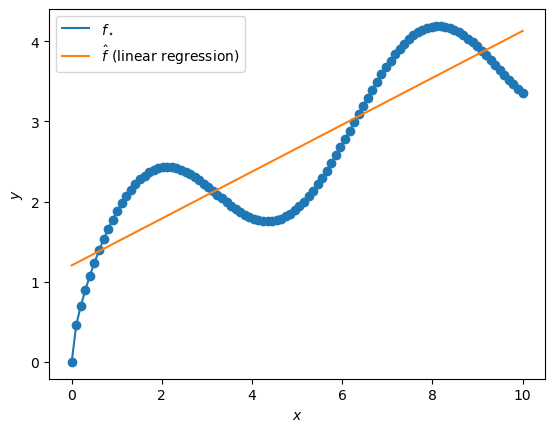

In [44]:
# plot truth and estimate
fig = plt.figure()
plt.scatter(x,y)
plt.plot(x,f_true(phi(x)),label="$f_\star$")
plt.plot(x,yp,label="$\hat f$ (linear regression)")
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$');

Now, create an instance of your network to carry out steps 1. and 2., by having it produce an output of size `k`, and using this output as an input in a 'standard' linear regression formulation.  

(Note: Step 3.-Regularization is of enormous importance (as you know by now), but in this exercise we are particularly interested in confirming the capacity/power of your network.)

In [45]:
k = 40
Z = np.zeros((len(x), k))  # this is what you need to replace with the output of your network

# TODO: Use your network to convert each x[i] into a random k-dimensional projection, Z[i] 
# Hint 1: Try with sizes [1, int(k/2), k]
# Hint 2: If you stick to linear activation functions, the result can only be linear!

# YOUR CODE HERE
N = Network([1, int(k/2), k], [Sigmoid, Identity])
for i in range(len(x)):
    Z[i] = N.feed_forward([x[i]])

fhat = linear_model.LinearRegression()
fhat.fit(Z,y)
yp = fhat.predict(Z)

Check graphically that the estimate fits the truth very well:

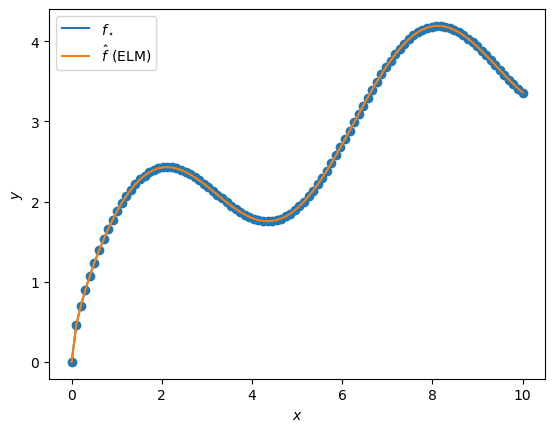

In [46]:
fig = plt.figure()
plt.scatter(x, y)
plt.plot(x, f_true(phi(x)), label="$f_\star$")
plt.plot(x, yp, label="$\hat f$ (ELM)")
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$');

Question/discussion point: Why don't we always use this technique?

We don't always use this technique because some problems can be solved using simpler models, that would require less computational power.
Moreover, we do not have total control on our model here, which is an advantage that simpler models have. Finally, we are not sure our activation function are the most optimal for the problem.

## Training the network (bonus but will give you a head start for lab 07)

While interesting, the `Network` class above is pretty useless as it stands since there is no way to learn a function we don't already know.  In this step, we will add the ability to train our network on a dataset using the gradient descent and back-propagation algorithms.  Let's review both of these algorithms now.

### (Stochastic) Gradient Descent

Recall from the beginning of the lab that we want to train the network parameters by minimizing a given loss function over an entire dataset. One method of doing this is using the gradient descent (GD) algorithm which you have already seen in the lectures and previous labs; recall the update rule:

$$
\theta = \theta - \eta \nabla_\theta \mathcal{L},
$$

where $\eta$ is the learning rate.  The update rule above is called GD because direction of change in the network parameters follow the opposite of the parameters' gradient in the loss function.  You can think of this like a ball rolling down a hill to find the minimum of the topology. Only in this case, the ball is massless because it has no momentum. Note that, contrary to linear and logistic regression, the loss / error function might not be convex, hence the existence of a unique minimizer isn't guaranteed, nor is it guaranteed that gradient descent will find it.

When the update rule is applied to a random subset of the total dataset, it is called stochastic gradient descent (SGD). SGD is far more efficient (computationally) than GD when the batch size is large enough to approximate the true gradients while being significantly smaller than the full dataset. Running over the entire dataset with SGD once is called an "epoch" (of training).

### Back-Propagation

From the GD update rule above, it is clear we will need to compute the gradients of the network parameters with respect to the cost function. This is exactly what back-propagation does, and thus is a crucial component to almost all neural network learning algorithms. In the next exercise, we will derive the 4 equations in back-propagation. You will need knowledge of the [chain rule for differentiation](https://en.wikipedia.org/wiki/Chain_rule) if you are not already familiar with this.

### Exercise 5: Derive backprop formulas

Before we start, it is convenient to define the following variable:

$$
\delta^l \equiv \frac{\partial \ell_p}{\partial z^l}.
$$

In other words, $\delta^l$ is the gradient of the loss function for a point $p$ with respect to the input to the activation function for the layer $l$ in our network.

1. What is the shape of $\delta^L$?

YOUR ANSWER HERE

2. Show that $\delta^L = \nabla_{a^L} \ell_p  \odot {\sigma'}^L ( z^L )$.

*Hint:* apply the chain rule to the definition of $\delta^L$.

YOUR ANSWER HERE

3. Show that for $l < L$, $\delta^l = [\delta^{l+1} (W^{l+1})^T ] \odot {\sigma'}^l ( z^l )$.

YOUR ANSWER HERE

4. Show that $\nabla_{W^l}\ell_p = (a^{l-1})^T \delta^l$.

*Hint:* use the definition of $z^l$ and derive w.r.t. a single component $W_{i,j}$.

YOUR ANSWER HERE

5. Show that $\nabla_{b^l}\ell_p = \delta^l$.

YOUR ANSWER HERE

Note that these four last formulas allow us to compute the gradient of the loss function for a single training point with respect to the parameters of our network.  Looking at the equations more closely, you should see a possible algorithm form.

1. Compute the values of $z^l$ and $a^l$ for $l = {1, \dots, L}$ by forward propagation through the network.  Recall $a^0 = x_p$: that's what we've implemented throughout Exercises 1-4.
2. Use the equation in Exercise 5.2 above to compute $\delta^L$.  
3. Back-propagate in the reverse direction using the equation in Exercise 5.3 to get all the other $\delta^l$ values.
4. Compute the parameter gradients using the equations in Exercises 5.4 and 5.5.

Note that this will yield the gradients for a single training point.  The gradients for the total loss function can easily be computed by

$$
\nabla_\theta \mathcal{L} = \sum_{p=1}^N \nabla_\theta \ell_p.
$$

Of course, the exact form of $\nabla_\theta \ell_p$ will depend on the choice of $\ell$.

We will implement this algorithm next week.